In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets
# visulisation function
from functions.visualisations import (
    histogram_trace, plot_linear_data,
    plot_y_timeseries, boxplot_weights,
    plot_ycorr_scatter,plot_confusion_matrix
)

from types import MethodType
np.random.seed(2023)


In [42]:

class LinearModel:
    '''
    Simple linear model with a single output (y) given the covariates x_1...x_M of the form:
    y = w_1 * x_1 + ... + w_M * x_M + b
    where M = number of features, w are the weights, and b is the bias.
    '''
    # Initialise values of model parameters
    def __init__(self,layer_sizes):
        self.w = None
        self.b = None 
        self.input_num=layer_sizes[0]
        self.output_num=layer_sizes[-1]
        self.n_params=(self.input_num*self.output_num)+self.output_num

    # Function to take in data and parameter sample and return the prediction
    def evaluate_proposal(self, data, theta):
        '''
        Encode the proposed parameters and then use the model to predict
        Input:
            data: (N x M) array of data
            theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        '''
        self.encode(theta)  # method to encode w and b
        prediction = self.predict(data)
        probs=self.softmax(prediction)
        prediction=np.argmax(probs,axis=1) # predict and return
        return prediction,probs

    # Linear model prediction
    def predict(self, x_in):
        y_out = x_in.dot(self.w) + self.b 
        return y_out
    
    # Helper function to split the parameter vector into w and band store in the model
    def encode(self, theta):
        self.w =  np.reshape(theta[:-self.output_num],(-1,self.output_num))
        self.b = theta[-1] 

    def softmax(self, x):
        '''
        Implentation of the softmax function
        '''
        prob = np.exp(x) / np.sum(np.exp(x))
        return prob
  


    def likelihood_function(self, theta,test=False):
        '''
        Calculate the likelihood of the data given the parameters
        Input:
            theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
            tausq: variance of the error term
        Output:
            log_likelihood: log likelihood of the data given the parameters
            model_prediction: prediction of the model given the parameters
            accuracy: accuracy (RMSE) of the model given the parameters
        '''
        # first make a prediction with parameters theta
        if test:
            x_data = self.x_test
            y_data = self.y_test
        else:
            x_data = self.x_data
            y_data = self.y_data
        # first make a prediction with parameters theta
        model_prediction,probs = self.model.evaluate_proposal(x_data, theta)
        model_simulation = model_prediction #+ np.random.normal(0,tausq,size=model_prediction.shape) 
        accuracy = self.accuracy(model_prediction, y_data) #RMSE error metric 
        # now calculate the log likelihood
        log_likelihood=0
        for ii in np.arange(x_data.shape[0]):
            for jj in np.arange(self.model.output_num):
                if y_data[ii]==jj:
                    log_likelihood+=np.log(probs[ii,jj])
        return [log_likelihood, model_prediction, model_simulation, accuracy] 

    # Define the prior
    def prior(self, sigma_squared,theta): 
        '''
        Calculate the prior of the parameters
        Input:
            sigma_squared: variance of normal prior for theta
            nu_1: parameter nu_1 of the inverse gamma prior for tau^2
            nu_2: parameter nu_2 of the inverse gamma prior for tau^2
            theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
            tausq: variance of the error term
        Output:
            log_prior: log prior
        '''
        n_params = self.theta_size # number of parameters in model
        part1 = -1 * (n_params / 2) * np.log(sigma_squared)
        part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
        log_prior = part1 - part2 
        return log_prior



In [43]:

# MCMC sampler
def sampler(self):
    '''
    Run the sampler for a defined linear model
    '''
    ## Define empty arrays to store the sampled posterior values
    # posterior of all weights and bias over all samples
    pos_theta = np.ones((self.n_samples, self.theta_size)) 
    # posterior defining the variance of the noise in predictions
    
    # record output f(x) over all samples
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record simulated values f(x) + error over all samples 
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record the RMSE of each sample
    accuracy_data = np.zeros(self.n_samples)
    # now for test
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_accuracy_data = np.zeros(self.n_samples)

    ## Initialisation
    # initialise theta - the model parameters
    theta = np.random.randn(self.theta_size)
    # make initial prediction
    pred_y[0,],_ = self.model.evaluate_proposal(self.x_data, theta)


    # calculate the prior
    prior_val = self.prior(self.sigma_squared,theta)
    # calculate the log-likelihood considering observations
    [likelihood, pred_y[0,], sim_y[0,], accuracy_data[0]] = self.likelihood_function(theta)

    n_accept = 0  
    ## Run the MCMC sample for n_samples
    for ii in np.arange(1,self.n_samples):
        # Sample new values for theta and tau using a Gaussian random walk
        theta_proposal = theta + np.random.normal(0, self.step_theta, self.theta_size)
        
        # calculate the prior
        prior_proposal = self.prior(
            self.sigma_squared, theta_proposal)
        # calculate the log-likelihood considering observations
        [likelihood_proposal, pred_y[ii,], sim_y[ii,], accuracy_data[ii]] = self.likelihood_function(
            theta_proposal)

         # calculate the test likelihood
        [_, test_pred_y[ii,], test_sim_y[ii,], test_accuracy_data[ii]] = self.likelihood_function(
            theta_proposal,test=True
        )

        # Noting that likelihood_function and prior_val return log likelihoods,
        # we can use log laws to calculate the acceptance probability
        diff_likelihood = likelihood_proposal - likelihood
        diff_prior = prior_proposal - prior_val

        mh_prob = min(1, np.exp(diff_likelihood + diff_prior))

        # sample to accept or reject the proposal according to the acceptance probability
        u = np.random.uniform(0, 1)
        if u < mh_prob:
            # accept and update the values
            n_accept += 1
            likelihood = likelihood_proposal
            prior_val = prior_proposal
            theta = theta_proposal
            # store to make up the posterior
            pos_theta[ii,] = theta_proposal
            
        else:
            # reject move and store the old values
            pos_theta[ii,] = pos_theta[ii-1,]
           



           
    # calculate the acceptance rate as a check
    accept_rate = (n_accept / self.n_samples) * 100
    print('{:.3f}% were accepted'.format(accept_rate))

    # store the posterior (samples after burn in) in a pandas dataframe and return
    self.pos_theta = pos_theta[self.n_burnin:, ]
    self.accuracy_data = accuracy_data[self.n_burnin:]



    # split theta into w and b
    results_dict = {'w{}'.format(_): self.pos_theta[:, _].squeeze() for _ in range(self.theta_size-1)}
    results_dict['b'] = self.pos_theta[:, -1].squeeze()
    #results_dict['tau'] = self.pos_tau.squeeze()
    results_dict['accuracy'] = self.accuracy_data.squeeze()

    # return the predictions
    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]

    results_df = pd.DataFrame.from_dict(
        results_dict
    )
    return results_df, pred_dict

In [44]:
class MCMC:
    def __init__(self,model, n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (N x M)
        self.y_data = y_data # (N x 1)
        self.x_test = x_test # (Nt x num_features)
        self.y_test = y_test # (Nt x 1)

        # MCMC sampler hyperparameters - defines the variance term in our Gaussian random walk
        self.step_theta = 0.02;  
        
        # model hyperparameters
        # considered by looking at distribution of  similar trained  models - i.e distribution of weights and bias
        self.sigma_squared = 5
    

        # initisalise the linear model class
        self.model = model
        self.theta_size = self.model.n_params # weights for each feature and a bias term (M+1)

        # store output
        self.pos_theta = None
     
        self.accuracy_data = None

        # functions defined above - this is poor practice, but done for readability 
        # and clarity
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior = MethodType(prior, self)
        self.sampler = MethodType(sampler, self)

    # Additional error metric
    @staticmethod
    def accuracy(predictions,targets):
        count= (predictions==targets).sum()
        return 100* (count/predictions.shape[0])
# load the data

name        = "Iris"
train_data   = np.loadtxt("data/{}/train.txt".format(name))
test_data    = np.loadtxt("data/{}/test.txt".format(name))

print('Training data shape: {}'.format(train_data.shape))
print('Test data shape: {}'.format(test_data.shape))
## MCMC Settings and Setup
n_samples = 25000 # number of samples to draw from the posterior
burn_in = int(n_samples* 0.25) # number of samples to discard before recording draws from the posterior

# or load from sunspot data
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]



Training data shape: (105, 5)
Test data shape: (45, 5)


In [45]:
## MCMC Settings and Setup
n_samples = 25000 # number of samples to draw from the posterior
burn_in = int(n_samples* 0.25) # number of samples to discard before recording draws from the posterior

# or load from sunspot data
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

if name in ['Iris']:
    layer_sizes = [x_data.shape[1], 3]
    data_case = 'classification'
elif name in ['Ionosphere']:
    layer_sizes = [x_data.shape[1], 2]
    data_case = 'classification'
else:
    raise ValueError('name is invalid.')

# Initialise the MCMC class
lm = LinearModel(layer_sizes=layer_sizes)
mcmc = MCMC(lm, n_samples, burn_in, x_data, y_data, x_test, y_test)
# Run the sampler
results, pred = mcmc.sampler()

84.628% were accepted


In [46]:
# gather the predicitons into useful variables
pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']

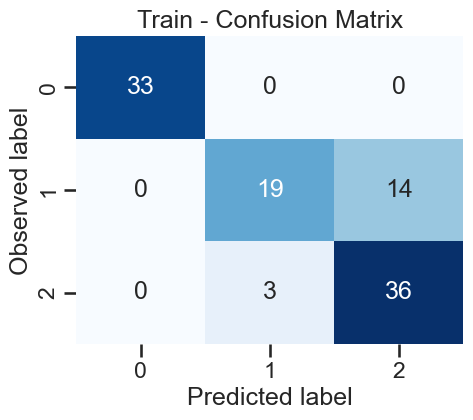

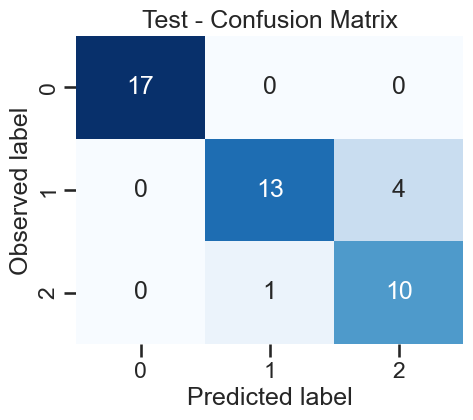

In [47]:
plot_confusion_matrix(y_data, pred_y, title='Train - Confusion Matrix')
plot_confusion_matrix(y_test, pred_y_test, title='Test - Confusion Matrix')

In [48]:
# Print the train/test accuracy
trainacc = np.array([mcmc.accuracy(pred_y[_,:], y_data) for _ in np.arange(pred_y.shape[0])])
testacc = np.array([mcmc.accuracy(pred_y_test[_,:], y_test) for _ in np.arange(pred_y_test.shape[0])])

print('Train accuracy: {:.3f}% ({:.3f})'.format(trainacc.mean(), trainacc.std()))
print('Test accuracy: {:.3f}% ({:.3f})'.format(testacc.mean(), testacc.std()))

Train accuracy: 83.737% (1.417)
Test accuracy: 84.746% (2.655)


In [49]:
def plot_hist(results, param_name):
    posterior_mean = results[param_name].mean()
    print('{:.3f} mean value of posterior'.format(posterior_mean))
    histogram_trace(results[param_name].values)

# use ipywidgets to get a "gui" dropdown to view all the parameters
interact(
    plot_hist, 
    results=fixed(results), 
    param_name=widgets.Dropdown(
        options=results.columns,
        value='w0',
        description='Parameter:',
    )
)
None

interactive(children=(Dropdown(description='Parameter:', options=('w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w…

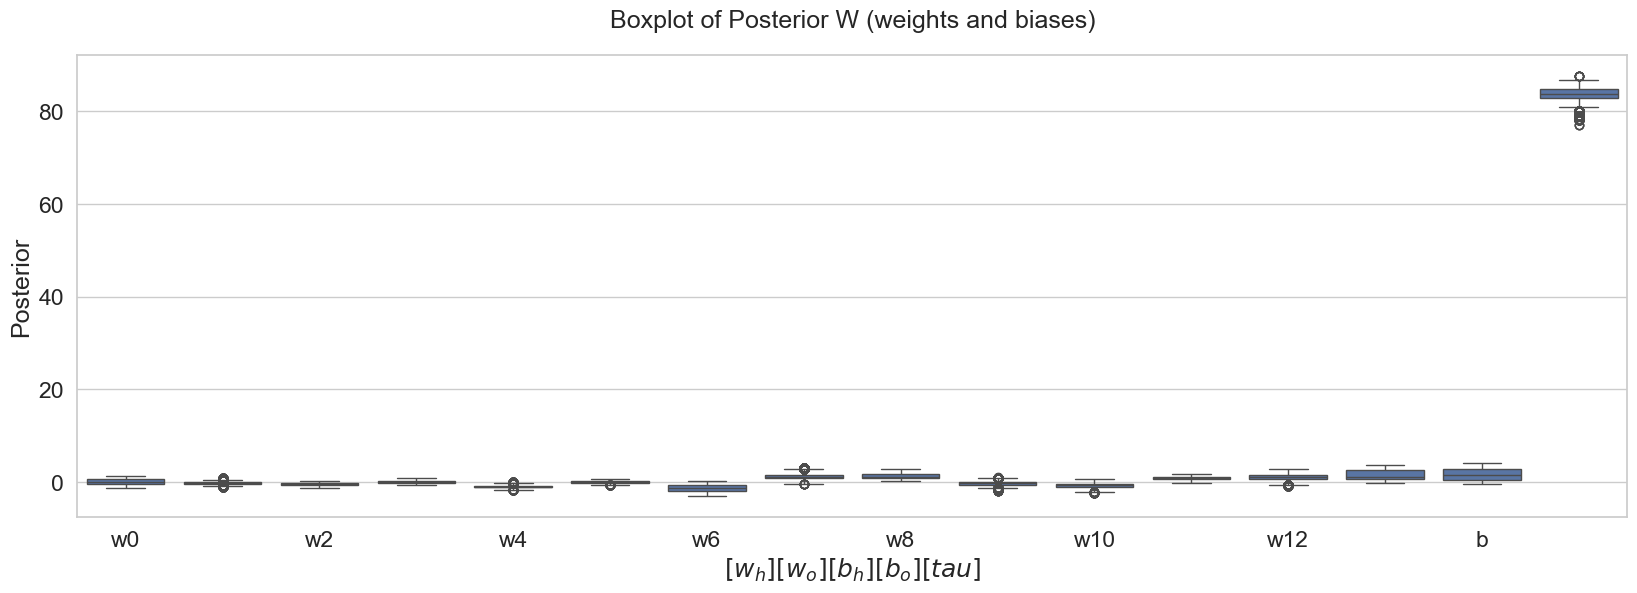

In [50]:
boxplot_weights(results,width=20)

In [51]:
import arviz as az
# Sample a second chain as more than one chain is required to generate the Rhat diagnostic
# Run second chain using a different seed
np.random.seed(2)
# setup second chain
mcmc_chain2 = MCMC(lm, n_samples, burn_in, x_data, y_data, x_test, y_test)
# Run the sampler
results_chain2, _ = mcmc_chain2.sampler()

# Now combine these two chains by stacking and convert to arviz dataset
# To convert to arviz, convert the pandas dataframe of samples into a dictionary of lists, stack and ingest into arviz
res_dict = results.to_dict(orient='list')
res_dict_chain2 = results_chain2.to_dict(orient='list')
# stack the chains looping through each parameter
az_results = az.from_dict({par: np.vstack([res_dict[par], res_dict_chain2[par]]) for par in res_dict})

# now we can use arviz to obtain summary statistics with Rhat ("r_hat") for each parameter.
az.summary(az_results)

85.152% were accepted


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,-0.042,0.519,-0.902,1.072,0.136,0.142,15.0,12.0,1.14
w1,0.041,0.418,-0.634,0.951,0.181,0.136,5.0,12.0,1.30
w2,-0.258,0.349,-0.968,0.326,0.136,0.101,7.0,16.0,1.23
w3,0.094,0.277,-0.502,0.556,0.064,0.046,20.0,34.0,1.11
w4,-1.051,0.259,-1.529,-0.595,0.089,0.066,9.0,141.0,1.19
w5,-0.092,0.237,-0.535,0.339,0.077,0.056,10.0,128.0,1.17
w6,-0.892,0.840,-2.491,0.596,0.414,0.317,4.0,12.0,1.43
w7,0.773,0.836,-0.982,2.170,0.360,0.270,5.0,20.0,1.28
w8,0.897,0.659,-0.080,2.377,0.352,0.273,4.0,12.0,1.52
w9,-0.652,0.791,-2.239,0.594,0.427,0.332,4.0,24.0,1.52
